In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

<h2>Preprocessing </h2>

In [3]:
data = pd.concat([train, test])

In [4]:
data.replace('Tỉnh Hòa Bình', 'Tỉnh Hoà Bình', inplace=True)
data.replace('Tỉnh Vĩnh phúc', 'Tỉnh Vĩnh Phúc', inplace=True)

Filling missing and nan value

In [5]:
category_cols = [
    'FIELD_8', 'FIELD_9', 'FIELD_10','FIELD_13','FIELD_17','FIELD_24','FIELD_39', 'FIELD_43',
]
not_use_cols = ['id', 'label', 'maCv', 'province', 'district', 'FIELD_7']

In [6]:
data[['age_source1', 'age_source2']] = data[['age_source1', 'age_source2']].fillna(-999)
data[['province', 'district', 'maCv'] + category_cols] = data[['province', 'district', 'maCv'] + category_cols].fillna('Missing')
data[['FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53']] = data[['FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53']].fillna(-99.0)

In [7]:
dict_map = {'NaN': -1,
           'Zero': 0,
           'One':1,
           'Two':2,
           'Three':3,
           'Four':4}
data['FIELD_35'] = data['FIELD_35'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -1,
           'I': 1,
           'II':2,
           'III':3,
           'IV':4,
           'V':4}
data['FIELD_41'] = data['FIELD_41'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -1,
           'Zezo': 0,
           'One':1}
data['FIELD_42'] = data['FIELD_42'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -1,
           'One':1,
           'Two':2}
data['FIELD_44'] = data['FIELD_44'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -999,
            'None': -1,
            'TRUE': 1,
            'FALSE':0
}
bool_cols = ['FIELD_18','FIELD_19','FIELD_20','FIELD_23','FIELD_25','FIELD_26','FIELD_27','FIELD_28','FIELD_29','FIELD_30',
            'FIELD_31','FIELD_36','FIELD_37','FIELD_38']
for col in bool_cols:
    data[col] = data[col].fillna('NaN').map(dict_map)
numberic_cols = ['FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_11', 'FIELD_21', 'FIELD_22', 'FIELD_45', 'FIELD_50', 'FIELD_51'
                , 'FIELD_52', 'FIELD_53']
for col in numberic_cols:
    data[col] = data[col].fillna(-999)

todo_cols = ['FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
for col in todo_cols:
    data[col] = data[col].fillna(-99.0).replace(['nan'], -1.0)

In [8]:
# data["maCv2"] = data["maCv"].str.lower()
# def job_category(maCv):
#     x = maCv.lower()
#     if type(x) == str:
#         if "công nhân" in x or "cnv" in x or "thợ may" in x or "cn" in x or "may công nghiệp" in x \
#         or "thợ sơn" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x:
#             return "CN"
#         elif "giáo viên" in x:
#             return "GV"
#         elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x:
#             return "NV"
#         elif "tài xế" in x or "lái xe" in x:
#             return "TX"
#         elif "undefined" in x:
#             return "undefined"
#         else:
#             return x
#     else:
#         return x
# data['maCv2'] = data['maCv'].apply(job_category).astype(str)

<h2>Feature Engineering </h2>

In [9]:
data['province'] = data['province'].apply(lambda x : str(x).lower())
data['district'] = data['district'].apply(lambda x : str(x).lower())
data['maCv'] = data['maCv'].apply(lambda x : str(x).lower())
data['is_province'] = data['province'].apply(lambda x : str(x).startswith('tỉnh')).astype('bool')
data['is_district'] = data['district'].apply(lambda x : str(x).startswith('huyện')).astype('bool')
data['len_FIELD_7'] = data['district'].apply(lambda x : len(list(x)))

In [10]:
# data['province'].apply(lambda x : str(x).startswith('tỉnh')).astype('bool')
data['FIELD_3_by_day'] = (data['FIELD_3'] - 337) % 365
# data['FIELD_3_by_month'] = (data['FIELD_3'] - 337) // 12
# data['FIELD_3_by_year'] = (data['FIELD_3'] - 337) // 365

In [11]:
data['FIELD_22_lg'] = train['FIELD_22'].apply(lambda x : np.log(x + 0.01)).fillna(-1)

In [12]:
# print(data['FIELD_4'].unique())
# print(data['FIELD_5'].unique())
# print(data['FIELD_6'].unique())

In [13]:
# data['autofe_456'] = data['FIELD_4']*100 + data['FIELD_5']*10 + data['FIELD_6']

In [14]:
# data['auto_FIELD_4_5_6'] = data['FIELD_4']*100 + data['']

In [15]:
from pyvi import ViTokenizer as tokenizer
def tokenize(s):
    return tokenizer.tokenize(str(s)).lower()
train['maCv'] = train['maCv'].apply(lambda x: tokenize(x))

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer().fit(data['maCv'])
vec = vectorizer.transform(data['maCv'])
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42).fit(vec)
svd_vec = svd.transform(vec)
data['maCv_vec0'], data['maCv_vec1'], data['maCv_vec2'] = svd_vec[:, 0], svd_vec[:, 1], svd_vec[: , 2]


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
field_7_str = data['FIELD_7'].fillna('[]').astype(str).apply(lambda x: ' '.join(ast.literal_eval(x)))
vectorizer = TfidfVectorizer().fit(field_7_str)
vec = vectorizer.transform(field_7_str)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42).fit(vec)
svd_vec = svd.transform(vec)
data['FIELD_7_vec0'], data['FIELD_7_vec1'] = svd_vec[:, 0], svd_vec[:, 1]

In [17]:
for col in category_cols + ['province', 'district', 'maCv']:
    field = dict(data[col].value_counts())
#     to_replace = []
#     for key, value in field.items():
#         if value < 2:
#             to_replace.append(key)
#     data[col] = data[col].replace(to_replace, 'UNKNOW')
    data[col+'_FREQ'] = data[col].map(field)

In [18]:
from sklearn import preprocessing
for col in category_cols + ['province', 'district', 'maCv']:
    le = preprocessing.LabelEncoder().fit(data[col])
    data[col] = le.transform(data[col])

In [19]:
# from sklearn.preprocessing import OneHotEncoder
# for col in ['FIELD_8', 'FIELD_10', 'FIELD_17', 'FIELD_24', 'FIELD_35', 'FIELD_41', 'FIELD_43', 'FIELD_44']:
#     data = pd.concat([data,pd.get_dummies(data[col], prefix=col,dummy_na=True)],axis=1)
# #     print(data[col].value_counts())

In [20]:
data['diff_age'] = abs(data['age_source1'] - data['age_source2'])


split

In [21]:
object_cols = [col for col in data.columns if data[col].dtype == 'object']
data[object_cols] = data[object_cols].astype('category')

In [22]:
train = data[data.label.notnull()]
test = data[data.label.isnull()]
test = test.drop(columns=['label'])
print(train.shape, test.shape)

(30000, 86) (20000, 85)


In [23]:
# train_woe = pd.read_csv('input/train_fe.csv')
# test_woe = pd.read_csv('input/test_fe.csv')
# # numberic_cols = ['new_FIELD_3','new_FIELD_50','FIELD_51','FIELD_52','FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
# fe_cols = [col for col in train_woe.columns if col not in ['id', 'label']]
# train[fe_cols] = train_woe[fe_cols]
# test[fe_cols] = test_woe[fe_cols]
# print(train.shape, test.shape)

In [24]:
train_cols = [col for col in train.columns if col not in not_use_cols]
train_X = train[train_cols]
train_y = train.label
print(train_X.shape, train_y.shape)

(30000, 80) (30000,)


In [25]:
train_y.value_counts()

0.0    29514
1.0      486
Name: label, dtype: int64

<h2>Hyperparams optimize </h2>

In [26]:
def gini(y_true, y_score):
    return roc_auc_score(y_true, y_score)*2 - 1

def lgb_gini(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'gini', gini(y_true, y_pred), True

In [27]:
# from bayes_opt import BayesianOptimization

# fold__ = 5
# def LGB_CV(
#           max_depth,
#           num_leaves,
#           min_data_in_leaf,
#           feature_fraction,
#           bagging_fraction,
#           lambda_l1,
#           lambda_l2,
#           learning_rate
#          ):
#     num_round = 10000
#     kfold = 5
#     folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=33)
#     oof = np.zeros(len(train_X))

#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
#         print("fold n°{}".format(fold_))
#         param = {
#             'num_leaves': int(num_leaves),
#             'min_data_in_leaf': int(min_data_in_leaf), 
#             'objective':'binary',
#             'max_depth': int(max_depth),
#             'learning_rate': learning_rate,
#             "feature_fraction": feature_fraction,
#             "bagging_freq": 1,
#             "bagging_fraction": bagging_fraction ,
#             "bagging_seed": 11,
#             "metric": 'auc',
#             "lambda_l1": lambda_l1,
#             "lambda_l2": lambda_l2,
#             'n_estimators': 1500,
#             'boosting' : 'gbdt',
#             "verbosity": -1,
#             'seed':int(2**fold__),
#             'bagging_seed':int(2**fold__),
#             'drop_seed':int(2**fold__)
#         }
#         trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx], categorical_feature=category_cols)
#         val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx], categorical_feature=category_cols)
#         clf = lgb.train(param, trn_data, num_round, feval = lgb_gini, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500, categorical_feature=category_cols)
#         oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
#         score_arr[fold_] = 2*roc_auc_score(train_y.iloc[val_idx], oof[val_idx]) - 1
# #         gc.collect()
        
#     return np.mean(score_arr)
# LGB_BO = BayesianOptimization(LGB_CV, {
#     'max_depth': (4, 10),
#     'num_leaves': (5, 130),
#     'min_data_in_leaf': (10, 150),
#     'feature_fraction': (0.7, 1.0),
#     'bagging_fraction': (0.7, 1.0),
#     'lambda_l1': (0, 1),
#     'lambda_l2': (0, 6),
#     'learning_rate':(0.005, 0.01)
# })

# LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)

In [28]:
# LGB_BO.max

<h2>Training model </h2>

In [29]:
num_round = 10000
kfold = 5
folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=33)
oof = np.zeros(len(train_X))
prediction = np.zeros(len(test))
score_arr = np.zeros(kfold)
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
    print("Fold {}".format(fold_))
    param = {'num_leaves': int(127.46944213018052),
            'min_data_in_leaf': int(142.8216562633925), 
            'objective':'binary',
            'max_depth': int(9.542177995080976),
            'learning_rate': 0.006001371601578423,
            "feature_fraction": 0.7106289550077538,
            "bagging_freq": 1,
            "bagging_fraction":  0.7896193631865245 ,
            "metric": 'auc',
            "lambda_l1": 0.27253575066409175,
            'n_estimators': 1500,
            'boosting' : 'gbdt',
            "verbosity": -1}
    trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx])#, categorical_feature=category_cols)
    val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx])#, categorical_feature=category_cols)
    clf = lgb.train(param, trn_data, num_round, feval = lgb_gini, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500)#, categorical_feature=category_cols)
    oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
#     prediction += clf.predict(test[train_cols], num_iteration=clf.best_iteration)
    score_arr[fold_] = 2*roc_auc_score(train_y.iloc[val_idx], oof[val_idx]) - 1
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_cols
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if fold_ != 3:
        prediction += clf.predict(test[train_cols], num_iteration=clf.best_iteration) / (folds.n_splits - 1)
print("CV mean score: {:<8.5f}".format(np.mean(score_arr)))
print("STD: {:<8.5f}".format(np.std(score_arr)))

Fold 0
Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.894416	training's gini: 0.788832	valid_1's auc: 0.666293	valid_1's gini: 0.332586
[200]	training's auc: 0.916443	training's gini: 0.832887	valid_1's auc: 0.669717	valid_1's gini: 0.339435
[300]	training's auc: 0.924094	training's gini: 0.848187	valid_1's auc: 0.674812	valid_1's gini: 0.349623
[400]	training's auc: 0.92943	training's gini: 0.858861	valid_1's auc: 0.666889	valid_1's gini: 0.333779
[500]	training's auc: 0.932875	training's gini: 0.865749	valid_1's auc: 0.662381	valid_1's gini: 0.324762
[600]	training's auc: 0.936228	training's gini: 0.872456	valid_1's auc: 0.659	valid_1's gini: 0.318
[700]	training's auc: 0.939295	training's gini: 0.878589	valid_1's auc: 0.655181	valid_1's gini: 0.310363
Early stopping, best iteration is:
[299]	training's auc: 0.923902	training's gini: 0.847804	valid_1's auc: 0.675754	valid_1's gini: 0.351508
Fold 1
Training until validation scores don't improve 

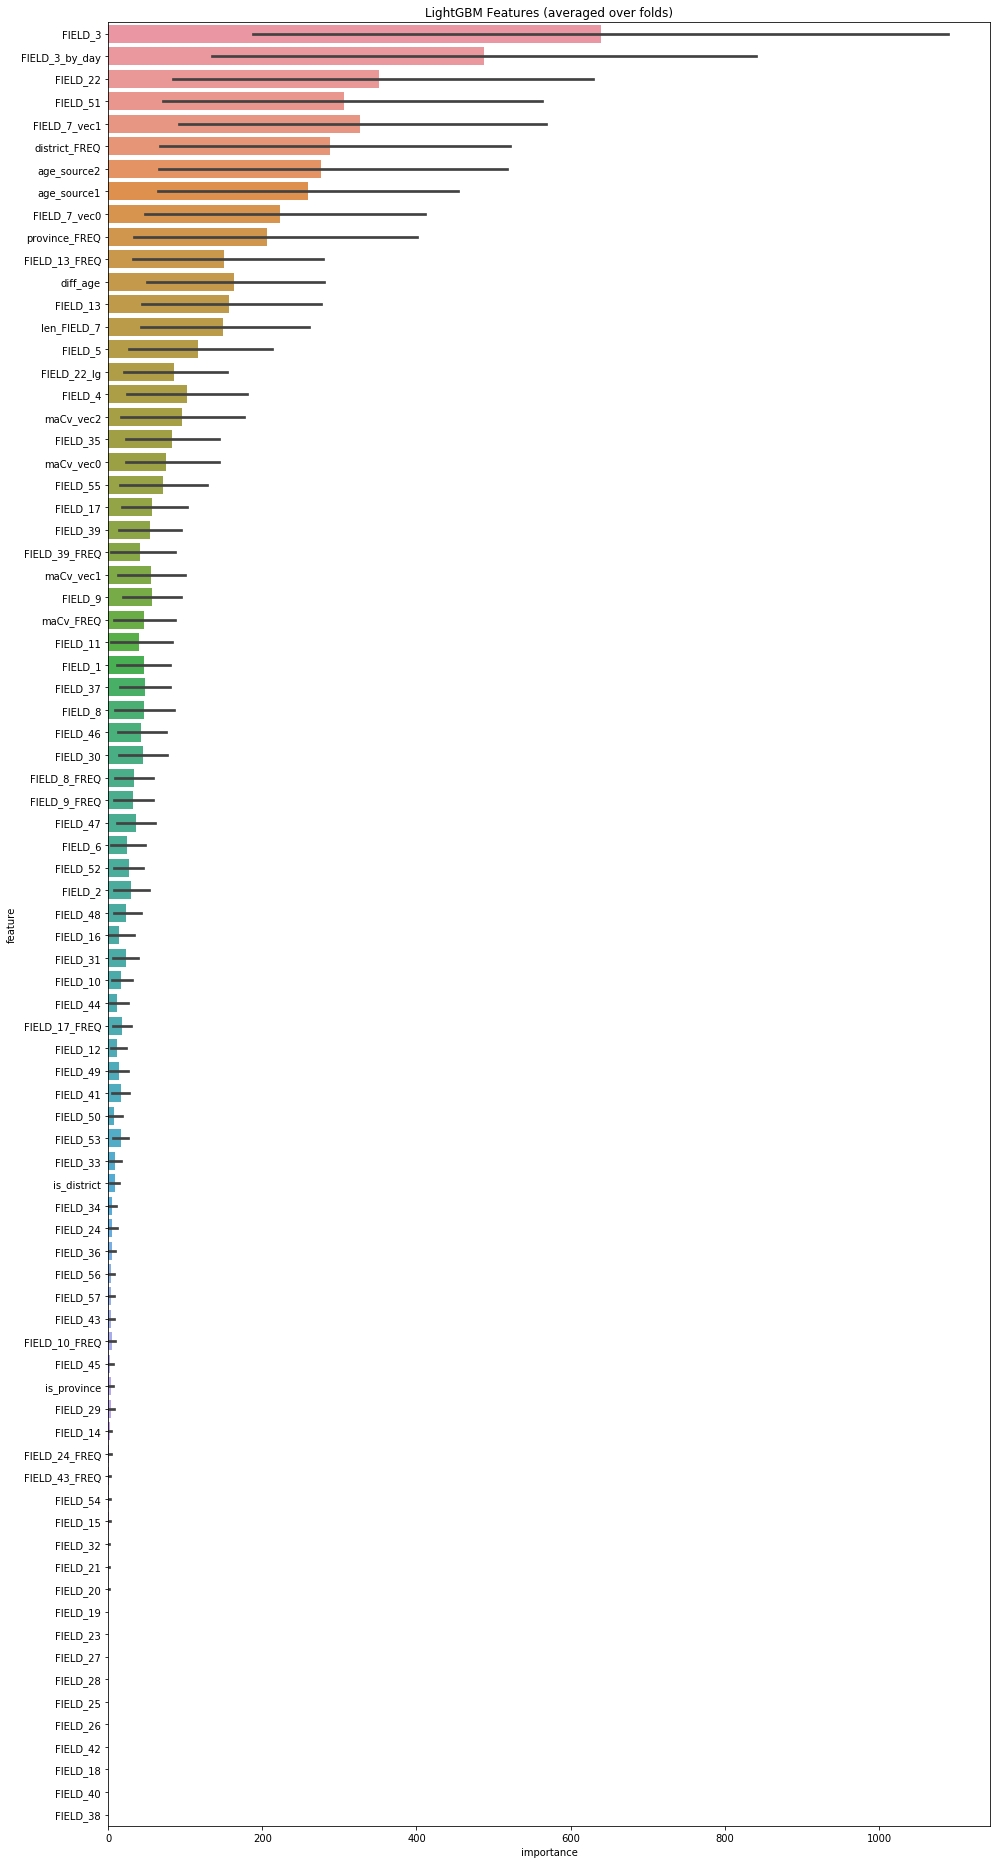

In [30]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [31]:

submission = pd.read_csv('input/sample_submission.csv')
submission['label'] = prediction
submission.to_csv('input/submission_bad_fold.csv', index=False)